In [1]:
pip install mesa

Note: you may need to restart the kernel to use updated packages.


## The initial model
Implementing the initial model without contagion. 
The neighbourhood is a grid of size $N^2 = C + R + S$. There are $C$ commericial properties, $R$ residential properties, and $S$ spaces designated for non-paying visitors to mill-around. These values are constant for all time, meaning that no residential properties can be turned into commercial properties, or vice versa. 



## Importing all of the libraries

In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
import numpy as np
import matplotlib.pyplot as plt
from mesa.space import MultiGrid, SingleGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
from mesa.visualization.UserParam import UserSettableParameter

make boolean decision with probability $p$

In [3]:
import random

def decision(probability):
    return random.random() < probability


## Example of popularity function 
probability/popularity of business as dependent on number of visitors
$$Popularity(N)=1-e^{-\lambda N}$$


In [4]:
def pop(n):
    l = 0.2
    p = 1 - np.exp(-l * n)
    if p >0.1:
        return p
    else:
        return 0.1

## Example of economic status function

The economic status of the business as a step function dependent on the popularity of the business. 


In [5]:
def e_stat(p):
    if p<=0.3:
        return 0
    if p>0.3 and p <= 0.6:
        return 1
    if p>0.6:
        return 2

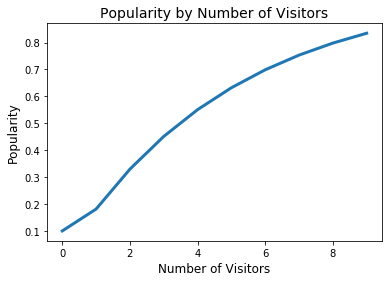

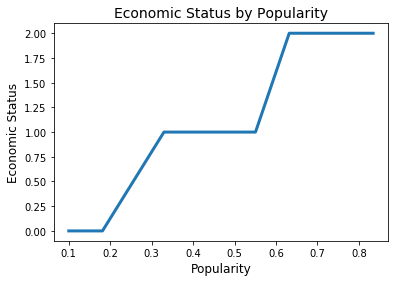

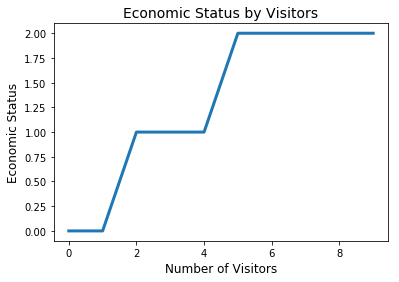

In [6]:
n = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
f = np.zeros(len(n))
e = np.zeros(len(n))
for i, N in enumerate(n):
    f[i] = pop(N)
for i, p in enumerate(f):
    e[i] = e_stat(p)
plt.plot(n, f, lw='3')
plt.xlabel('Number of Visitors', fontsize='12')
plt.ylabel('Popularity', fontsize='12')
plt.title('Popularity by Number of Visitors', fontsize='14')
plt.show()
plt.plot(f, e, lw='3')
plt.xlabel('Popularity', fontsize='12')
plt.ylabel('Economic Status', fontsize='12')
plt.title('Economic Status by Popularity', fontsize='14')
plt.show()
plt.plot(n, e, lw='3')
plt.xlabel('Number of Visitors', fontsize='12')
plt.ylabel('Economic Status', fontsize='12')
plt.title('Economic Status by Visitors', fontsize='14')
plt.show()

## Creating the agents
Each of our agents has the following properties:

in_neighbourhood := True or False

econ_status := Low, Medium, or High, represented as 0, 1, 2, respectively

resident_status := Resident or Visitor, represented as 0, 1, respectively

prob_enter := Probability of agent entering the neighbourhood, real value in (0,1)


Each of our agents can make the following decisions:

buy_or_sell := the decision to buy or sell your residence. This is a function of in_neighbourhood, resident_status, econ_status, and the availability of accessible properties in the neighbourhood. 

enter_or_leave := the decision to enter or leave the neighbourhood. This is a function of in_neighbourhood, resident_status, and prob_enter

visit_business := the decision to visit a business. This is a function of in_neighbourhood, econ_status, and the attributes of the businesses. 

In [7]:
class Person(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model, IN=True):
        super().__init__(unique_id, model)
        self.yelped = False
        if IN:
            self.econ_status = np.random.choice([0,1,2], p = [0.6, 0.3, 0.1])#RANDOM INITIALIZATION OF ECONOMIC STATUS. CAN CHANGE.
        else:
            self.econ_status = np.random.choice([0,1,2], p = [0.2, 0.3, 0.5])#RANDOM INITIALIZATION OF ECONOMIC STATUS. CAN CHANGE.
        self.prob_enter = np.random.normal(0.3,0.15)
        

    def buy_or_sell(self):
        if self.in_neighbourhood:
            if self.resident_status:
                residence = self.model.grid.get_cell_list_contents([self.Home])
                home = [obj for obj in residence if isinstance(obj, Residential)]
                home = home[0]
                med_all = med_property_value(self.model)
                good_offer = np.random.choice([0,1], p=[0.1, 0.9])
                if self.econ_status < home.property_value:
                    y = random.randrange(self.model.grid.height)
                    if y != self.model.grid.height:
                        self.model.grid.move_agent(self, (y, self.model.grid.width-1))
                    else:
                        self.model.grid.move_agent(self, (y-1, self.model.grid.width-1))
                    self.prob_enter = self.prob_enter *0.5
                    self.resident_status = False
                    self.in_neighbourhood = False
                    home.vacancy = True
                elif good_offer == 0 and self.econ_status < med_all:
                    y = random.randrange(self.model.grid.height)
                    if y != self.model.grid.height:
                        self.model.grid.move_agent(self, (y, self.model.grid.width-1))
                    else:
                        self.model.grid.move_agent(self, (y-1, self.model.grid.width-1))
                    self.prob_enter = self.prob_enter *0.5
                    self.resident_status = False
                    self.in_neighbourhood = False
                    home.vacancy = True
                #aa = home.vacancies
                #if home.vacancy:
                #    home.vacancies = np.hstack((aa, np.asarray(0)))
                #else:
                #    home.vacancies = np.hstack((aa, np.asarray(1)))
                    
            if not self.resident_status:
                residences = [res for res in self.model.schedule.agents if isinstance(res, Residential)]
                houses_for_sale = [obj for obj in residences if obj.vacancy]
                affordable_homes = [obj for obj in houses_for_sale if (obj.property_value <= self.econ_status)]
                if len(affordable_homes) != 0:
                    new_house = np.random.choice(affordable_homes) #pick a random affordable home to buy
                    self.model.grid.move_agent(self, new_house.pos)#move in!
                    self.Home = new_house.pos #update the location of your home.
                    self.resident_status = True #update your resident status
                    new_house.vacancy = False
                    self.in_neighbourhood = True
                    #print('me:', self.econ_status, 'newhouse before:', new_house.property_value)
                    new_house.property_value = self.econ_status #possibly increase property value of your home!
                    #print('newhouse after:', new_house.property_value)
                else:
                    self.prob_enter = self.prob_enter * 0.8
                    
    def enter_or_leave(self):
        #print('enter or leave')
        if self.in_neighbourhood and not self.resident_status: #if in neighbourhood but not resident
            d = decision(self.prob_enter) #Will return False with probability 1-prob_enter
            if d == False:
                y = random.randrange(self.model.grid.height)
                if y != self.model.grid.height:
                    self.model.grid.move_agent(self, (y, self.model.grid.width-1))
                else:
                    self.model.grid.move_agent(self, (y-1, self.model.grid.width-1))
                    
        if not self.in_neighbourhood: 
            self.in_neighbourhood = decision(self.prob_enter)
            if self.in_neighbourhood:
                streets = [s for s in self.model.schedule.agents if isinstance(s, Street)]
                st = np.random.choice(streets)
                self.model.grid.move_agent(self, st.pos)
    
    def shop(self):
        #print('shop')
        if self.in_neighbourhood:
            businesses = [b for b in self.model.schedule.agents if isinstance(b, Commercial)]
            popularity = [obj.popularity for obj in businesses]
            sums = sum(popularity)
            popularity = np.asarray(popularity)/sums
            store = np.random.choice(businesses, p=popularity)
            if store.econ_status <= self.econ_status:
                self.model.grid.move_agent(self, store.pos)
                self.prob_enter = self.prob_enter * 1.2 #increase probability of entering
                if store.popularity > 0.7:
                    sh = np.random.choice([0,1], p=[0.8, 0.2])
                    if sh == 0 :
                        self.share(store)
                        self.yelped = True
                
            else:
                self.prob_enter = self.prob_enter * 0.8 #decrease probability of entering
    
    def go_home(self):
        #print('shop')
        if self.resident_status:
            self.model.grid.move_agent(self, self.Home)
            
    def share(self, store):
        print('share')
        yelp = 1.3 * store.popularity
        store.popularity = yelp
        store.yelped = True
        non_residents = [b for b in self.model.schedule.agents if isinstance(b, Person) and not b.in_neighbourhood]
        for b in non_residents:
            pyelp = 1.3 * b.prob_enter
            b.prob_enter = pyelp
            
                
    def step(self):
        #print('here in person')
        action = np.random.choice([0,1,2,3], p=[0.15,0.3,0.4,0.15])
        if action == 0:
            self.buy_or_sell()
        if action == 1:
            self.enter_or_leave()
        if action == 2:
            self.shop()
        if action == 3:
            self.go_home()

## The Commercial Agent
each business has the following properties:

number_of_visitors := the number of visitors at a given time step

popularity := value in $(0,1)$ that reflects the popularity of the business. Also used as a probability of the business being visited. This is a function of number_of_visitors

econ_status := Low, Medium, or High, represented as 0, 1, 2, respectively. This increases with popularity. For $popularity \leq 0.33$, the econ_status is low. For $0.33<popularity \leq0.66$, econ_status is medium. For $0.33 < popularity \leq 0.99$, econ_status is high.

Each of our businesses can do the following things:

count_visits:=count the number of agents in the business

In [8]:
class Commercial(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.econ_status = np.random.choice([0,1,2], p = [0.7, 0.2, 0.1]) 
        if self.econ_status == 0:
            self.popularity = 0.2
            self.number_of_visitors = 1
        if self.econ_status == 1:
            self.popularity = 0.5
            self.number_of_visitors = 4
        if self.econ_status == 2:
            self.popularity = 0.8
            self.number_of_visitors = 8
        self.avgs = [self.number_of_visitors]
        self.av_ppl = np.average(np.asarray(self.avgs))
        

    def count_visits(self):
        same_space = self.model.grid.get_cell_list_contents([self.pos])
        visitors = [obj for obj in same_space if isinstance(obj, Person)]
        self.number_of_visitors = len(visitors)
        self.avgs = np.hstack((np.asarray(self.avgs), np.asarray(self.number_of_visitors)))
        if len(self.avgs) > 50:
            self.avgs = self.avgs[:-50]
        self.av_ppl = np.average(np.asarray(self.avgs))
        self.popularity = pop(self.av_ppl)
        self.econ_status = e_stat(self.popularity)
        
        neighbours = self.model.grid.get_neighbors(self.pos, moore=True, include_center=True, radius=1)
        neighbours = [n for n in neighbours if isinstance(n, Commercial)]
        neighbourh = [n for n in neighbours if isinstance(n, Residential)]
        a = [obj.econ_status for obj in neighbours]
        b = [obj.property_value for obj in neighbourh]
        all_p_vals = np.hstack((np.asarray(a), np.asarray(b)))
        if len(all_p_vals) != 0:
            m = np.median(all_p_vals)
            choice = np.random.choice([0,1])
            if choice == 0:
                if np.int(np.ceil(m)) > self.econ_status:
                    self.econ_status = np.int(np.ceil(m))   
    def step(self):
        #print('here in bus')
        self.count_visits()

## The Residential Agent
each residence has the following properties:

property_value := Low, Medium, or High, represented as 0, 1, 2, respectively.

vacancy := True or False boolean reflecting ownership

In [9]:
class Residential(Agent):
    """ A residence with property value and vacancy status"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.property_value = np.random.choice([0,1,2], p = [0.8, 0.15, 0.05]) #JUST AN INITIALIZATION. WILL NEED TO FIX FOR INITIAL CONDITIONS
        self.vacancy = True
        #self.vacancies = np.array([0])

    def step(self):
        #print('here in res')
        neighbours = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False, radius=1)
        neighbours = [n for n in neighbours if isinstance(n, Residential)]
        a = [obj.property_value for obj in neighbours]
        neighboursc = [n for n in neighbours if isinstance(n, Commercial)]
        b = [obj.property_value for obj in neighboursc]
        all_p_vals = np.hstack((np.asarray(a), np.asarray(b)))
        if len(all_p_vals) != 0:
            m = np.median(all_p_vals)
            choice = np.random.choice([0,1])
            if choice == 0:
                if np.int(np.ceil(m)) > self.property_value:
                    self.property_value = np.int(np.ceil(m))
        #if np.asarray(self.vacancies[:-20]).any() == np.zeros(len(self.vacancies[:-20])).any():
        #    if self.property_value > 0:
        #        self.property_value = self.property_value-1 
        #print('property_value:',self.property_value,'vacant:', self.vacancy)

## The Street Agent
A square of street that out-of-towners can visit to window shop and consider buying a residence or visiting a shop

number_of_visitors := number of people on that square of street

In [10]:
class Street(Agent):
    """ a square of street for window shoppers """
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.number_of_visitors = 0
        
    def count_visits(self):
        same_space = self.model.grid.get_cell_list_contents([self.pos])
        visitors = [obj for obj in same_space if isinstance(obj, Person)]
        self.number_of_visitors = len(visitors)
    
    def step(self):
        #print('here in street')
        self.count_visits()

## Helper functions for data collection

In [11]:
def people_on_street(model):
    street_visits = [agent.number_of_visitors for agent in model.schedule.agents if isinstance(agent, Street)]
    return sum(street_visits)
def people_in_neighbourhood(model):
    people = [agent for agent in model.schedule.agents if isinstance(agent, Person) and agent.in_neighbourhood]
    return len(people)
def med_property_value(model):
    prop_vals = [prop.property_value for prop in model.schedule.agents if isinstance(prop, Residential)]
    return np.median(prop_vals)
def med_econ_status_res(model):
    econ_stats = [agent.econ_status for agent in model.schedule.agents if isinstance(agent, Person) and agent.resident_status]
    return np.median(econ_stats)
def med_econ_status_visitors(model):
    econ_stats = [agent.econ_status for agent in model.schedule.agents if isinstance(agent, Person) and not agent.resident_status and agent.in_neighbourhood]
    return np.median(econ_stats)
def yelpers(model):
    yelpers = [agent for agent in model.schedule.agents if isinstance(agent, Person) and agent.yelped]
    for agent in yelpers:
        agent.yelped = False
    return len(yelpers)
def med_visits(model):
    bus_visits = [bus.number_of_visitors for bus in model.schedule.agents if isinstance(bus, Commercial)]
    return np.median(bus_visits)
def med_pop(model):
    bus_pop = [bus.popularity for bus in model.schedule.agents if isinstance(bus, Commercial)]
    return np.median(bus_pop)
def vacant_high(model):
    r = [p for p in model.schedule.agents if isinstance(p, Residential) and p.vacancy and p.property_value==2]
    return len(r)
    


## The neighbourhood

NOTE: for some reason, the residences become businesses... why?


In [12]:
class Gentrified_Neighbourhood(Model):
    def __init__(self, N, I, J, R, C, S, width, height):
        self.running = True
        
        self.num_people = N
        # N = I + J
        self.num_in_neighbourhood = I
        self.num_out_neighbourhood = J
        
        self.num_res = R
        self.num_com = C
        self.num_street = S
        
        
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        # Create agents
        available = []
        indices = []
        count = 0
        
        for i in range(height):
            for j in range(width-1):
                available.append((i,j))
                indices.append(count)
                count += 1
                
        #print('len available:', len(available), 'len indicies:', len(indices))        
        occupied = []
        res = []
        res_ind = []
        count = 0
        sched = 0
        for i in range(self.num_res): #place residences randomly
            a = Residential(sched, self)
            placed = False
            while not placed:
                position = np.random.choice(indices)
                indices.remove(position)
                position = available[position]
                #if (x,y) is valid and it doesn't already have a house on it, add a house
                if position not in occupied:
                    self.grid.place_agent(a, position)
                    self.schedule.add(a)
                    occupied.append(position)
                    res.append(position)
                    res_ind.append(count)
                    count += 1
                    placed = True
                    sched += 1
                    
                else: 
                    print('something wrong 1')
                
        for i in range(self.num_com): #place commercial randomly
            a = Commercial(sched, self)
            placed = False
            while not placed:
                position = np.random.choice(indices)
                indices.remove(position)
                position = available[position]
                #if (x,y) is valid and it doesn't already have a property on it, add a business
                if position not in occupied:
                    self.grid.place_agent(a, position)
                    self.schedule.add(a)
                    occupied.append(position)
                    placed = True
                    sched += 1
                
        for i in range(self.num_street):
            a = Street(sched, self)
            placed = False
            while not placed:
                position = np.random.choice(indices)
                indices.remove(position)
                position = available[position]
                #if (x,y) is valid and it doesn't already have a property on it, add a business
                if position not in occupied:
                    self.grid.place_agent(a, position)
                    self.schedule.add(a)
                    occupied.append(position)
                    placed = True
                    sched += 1
        
        homes = []
        
        for i in range(self.num_in_neighbourhood):
            a = Person(sched, self, True)
            placed = False
            while not placed:
                position = np.random.choice(res_ind)
                res_ind.remove(position)
                position  = res[position]
                if position not in homes:
                    self.grid.place_agent(a, position)
                    self.schedule.add(a)
                    a.Home = position
                    a.resident_status = True
                    a.in_neighbourhood = True
                    homes.append(position)
                    a.home = position
                    Res = self.grid.get_cell_list_contents(position)
                    home = [obj for obj in Res if isinstance(obj, Residential)]
                    home = home[0]
                    home.vacancy = False
                    a.econ_status = home.property_value
                    placed = True
                    sched += 1
                
        for i in range(self.num_out_neighbourhood):
            a = Person(sched, self, False)
            placed = False
            while not placed:
                y = random.randrange(self.grid.height)
                if y != self.grid.height:
                    self.grid.place_agent(a, (y, self.grid.width-1))
                    self.schedule.add(a)
                    a.resident_status = False
                    a.in_neighbourhood = False
                    placed = True
                    sched += 1
        
        self.datacollector = DataCollector(
            model_reporters={"Median popularity of businesses": med_pop, "Number of people sharing": yelpers, "Vacant homes with high property value": vacant_high, "People on the Street": people_on_street, "People in the Neighbourhood": people_in_neighbourhood, "Median Property Value": med_property_value, "Median Economic Status of Residents": med_econ_status_res, "Median Economic Status of Visitors": med_econ_status_visitors, "Median number of visitors to businesses": med_visits} ) 
        #self.datacollector = DataCollector(
         #   model_reporters={"Median popularity of businesses": med_pop, "Vacant homes with high property value": vacant_high, "People on the Street": people_on_street, "People in the Neighbourhood": people_in_neighbourhood, "Median Property Value": med_property_value, "Median Economic Status of Residents": med_econ_status_res, "Median Economic Status of Visitors": med_econ_status_visitors, "Median number of visitors to businesses": med_visits} ) 


    def step(self):
        #print('here in model')
        self.datacollector.collect(self)
        self.schedule.step()
        

## Portrayal of neighbourhood
Agents are light green, medium green, and dark green grid squares for low, medium, and high economic status, respectively. Commercial businesses are light red, medium red, and dark red grid squares for low, medium, and high economic status, respectively.
Residences are light purple, medium purple, and dark purple, for low, medium, and high property value, respectively.
Streets are cyan.

In [13]:
def agent_portrayal(agent):
    if agent is None:
        return
    
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if type(agent) is Person:
        portrayal["Layer"] = 1
        portrayal["r"] = 0.4
        #if agent.yelped:
         #   portrayal["Color"] = "black"
        if agent.econ_status == 0:
            portrayal["Color"] = "#A9F5A9"
        elif agent.econ_status == 1:
            portrayal["Color"] = "#01DF01"
        elif agent.econ_status == 2:
            portrayal["Color"] = "#088A08"
        else:
            portrayal["Shape"] = "rect"
            portrayal["Color"] = "black"
            
    elif type(agent) is Residential:
        portrayal["Shape"] = "rect"
        portrayal["Layer"] = 0
        portrayal["w"] = 1
        portrayal["h"] = 1
        if agent.vacancy:
            portrayal["Color"] = "white"
        elif agent.property_value == 0:
            portrayal["Color"] = "#E3CEF6"
        elif agent.property_value == 1:
            portrayal["Color"] = "#BE81F7"
        elif agent.property_value == 2:
            portrayal["Color"] = "#7401DF"
        else:
            portrayal["Shape"] = "circle"
            portrayal["Color"] = "#7401DF"
            portrayal["r"] = 0.7
            
    elif type(agent) is Commercial:
        portrayal["Shape"] = "rect"
        portrayal["Layer"] = 0
        portrayal["w"] = 1
        portrayal["h"] = 1
        if agent.econ_status == 0:
            portrayal["Color"] = "#F6CECE"
        elif agent.econ_status == 1:
            portrayal["Color"] = "#F78181"
        elif agent.econ_status == 2:
            portrayal["Color"] = "#DF0101"
        else:
            portrayal["Shape"] = "circle"
            portrayal["Color"] = "#DF0101"
            portrayal["r"] = 0.7
            
    elif type(agent) is Street:
        portrayal["Color"] = "grey"
        portrayal["Shape"] = "rect"
        portrayal["Layer"] = 0
        portrayal["w"] = 1
        portrayal["h"] = 1
        
    return portrayal


## SET UP
Ignore this too!

In [14]:
model = Gentrified_Neighbourhood(20, 20, 20, 20, 8, 2, 6, 6)
for i in range(5):
    print(i)
    model.step()
    

0
1
2
3
4


/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
i=2

In [16]:

grid = CanvasGrid(agent_portrayal, 20, 20, 500, 500)

chart2 = ChartModule([{"Label": "Vacant homes with high property value",
                      "Color": "Black"}], data_collector_name='datacollector')

# chart = ChartModule([{"Label": "Median Property Value",
#                       "Color": "Black"}, {"Label": "Median Economic Status of Residents",
#                       "Color": "Red"},{"Label": "Median Economic Status of Visitors",
#                       "Color": "Blue"}],
#                     data_collector_name='datacollector')

# chart3 = ChartModule([{"Label": "Median popularity of businesses",
#                       "Color": "Black"}],
#                     data_collector_name='datacollector')

# chart4 = ChartModule([{"Label": "Number of people sharing",
#                       "Color": "Black"}],
#                     data_collector_name='datacollector')


# chart5 = ChartModule([{"Label": "Median number of visitors to businesses",
#                       "Color": "Black"}],
#                     data_collector_name='datacollector')



n_slider = UserSettableParameter('slider', "Number of Initial Residents", 250, 100, 360, 10)
p_slider = UserSettableParameter('slider', "Number of People Outside the Neighbourhood", 100, 10, 700, 10)
h_slider = UserSettableParameter('slider', "Number of Homes", 260, 100, 360, 10)
c_slider = UserSettableParameter('slider', "Number of Businesses", 70, 20, 360, 10)


server = ModularServer(Gentrified_Neighbourhood,
                       [grid, chart2], #, chart2, chart3, chart4, chart5],
                       "Gentrified Neighbourhood",
                       {"N": 120, "I": n_slider, "J": p_slider, "R":h_slider, "C":c_slider, "S":10, "width": 20, "height": 20})

server.port = 8632+i
i=i+1
server.launch()

Interface starting at http://127.0.0.1:8634


In [17]:
np.asarray([2,3,4])

array([2, 3, 4])

In [18]:
li = []
len(li)

0

In [19]:
np.random.normal(0.5,0.15)

0.466705219051133

In [20]:
a = np.array([1,2,3,4,5,6,7,8])
b = np.array([2])
c = np.hstack((a,b))
c

array([1, 2, 3, 4, 5, 6, 7, 8, 2])

In [21]:
a = np.zeros(30)
b = np. zeros(30)
b[-1]=1

Socket opened!
{"type":"get_params"}
{"type":"reset"}
{"type":"get_step","step":1}


/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step","step":34}
